# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>


# Giovanni BENEDETTI DA ROSA

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

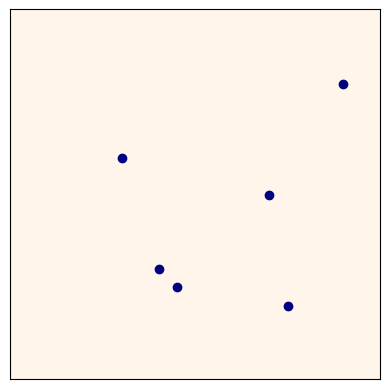

In [ ]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

**Answer:**

The network consists of a dynamic number of hidden layers (`nlayers`), each comprising a linear layer followed by an ELU activation function. The input dimension for the first hidden layer is n_in, and for subsequent layers, it is n_hid.

Then, a final output layer is defined after the hidden layers, consisting of a linear layer followed by a sigmoid activation function to scale the output between 0 and 1. The output layer transforms the hidden units into n_out output features.

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

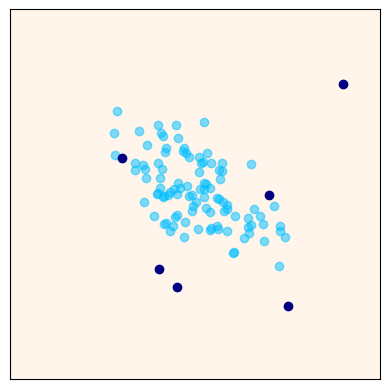

In [ ]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
# Draw a batch x of generated points
z = torch.randn(b, n_in).to(device)  # Input noise z: standard normal with shape (b, n_in)
x = G(z)  # Generated data points

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

**Answer:** The clip_value has a highly influence on the regularization of the model, enforcing the Lipschitz Continuity, by "clipping" the weights to stay in a range . So, if we reduce a lot the clip_values, it imposes strict regularity on the discriminator's weight updates. This high level of constraint has limit the discriminator’s capacity to model complex data patterns effectively. On the other hand if we we increase a lot this value, it decreases the regularization imposed on the discriminator’s weights. This relaxation permits greater variability in weight updates, enhancing the discriminator's ability to learn nuanced differences between real and fake data distributions. Unfortunaley, this can introduce oscilations and problems of convergence.

[0/1000], -0.007124


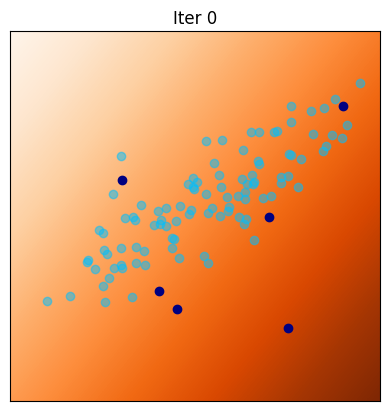

[100/1000], -0.005274


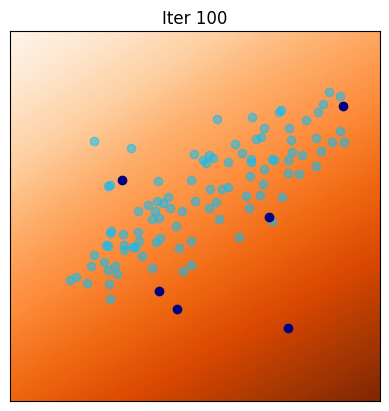

[200/1000], -0.005249


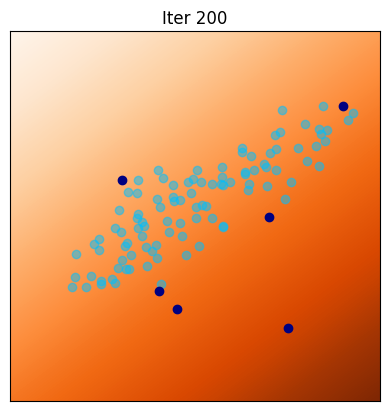

[300/1000], -0.004595


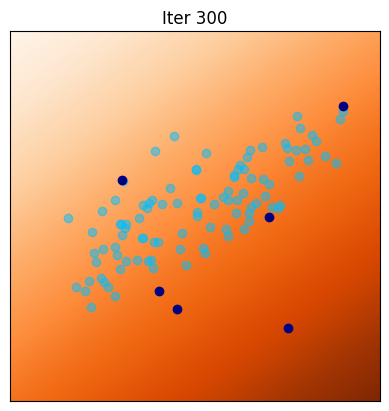

[400/1000], -0.007508


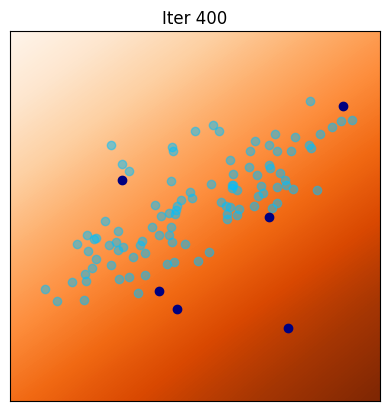

[500/1000], -0.005657


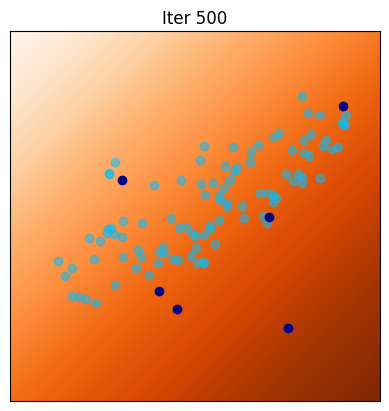

[600/1000], -0.007724


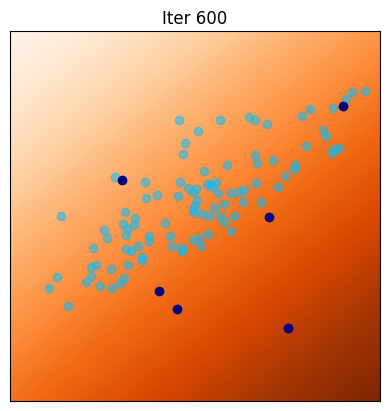

[700/1000], -0.006952


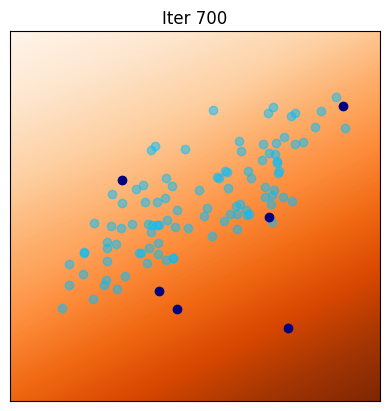

[800/1000], -0.007063


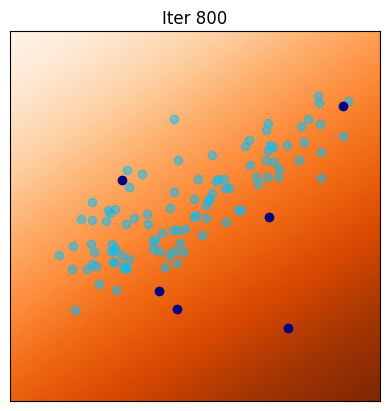

[900/1000], -0.006898


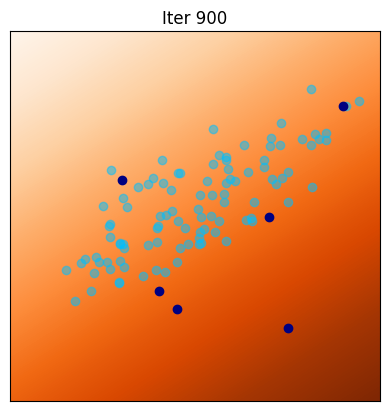

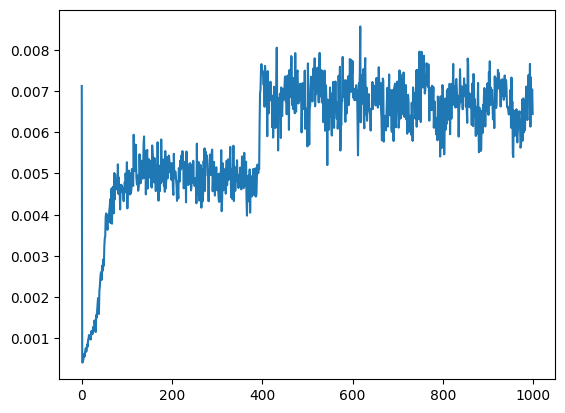

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):


    # Generate fake data
    z = torch.randn(b, n_in, device=device)  # Random noise
    fake_data = G(z).detach()

    # Calculate discriminator loss on real and fake data
    pred_fake = D(fake_data).mean()
    pred_real = D(y).mean()
    Dloss = pred_fake - pred_real # Maximize this loss (minimize -Dloss)

    # Backpropagate
    Dloss.backward()
    optimD.step()

    ### ... Weight Clipping ... ###
    for p in D.parameters():
      p.data.clamp_(-clip_value, clip_value)


    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [ ]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [ ]:
print("Lipschitz Constant =  " + str(lipconstant(D, x, y).item()))

Lipschitz Constant =  0.06044255569577217


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [ ]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    epsilon = 1e-12
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + epsilon)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

tensor(0.8828, grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=8.5438, Lip(D)=0.0817


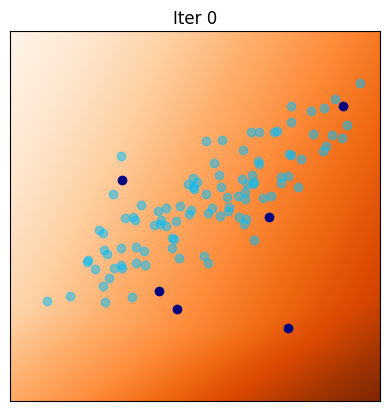

[100/1000], Dloss=0.0389, Lip(D)=0.9618


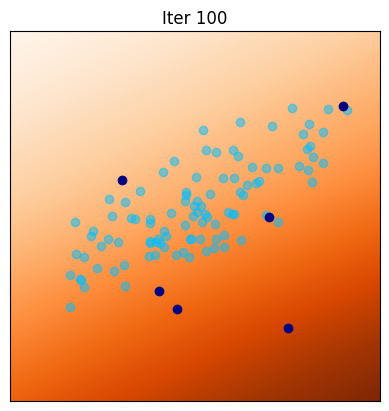

[200/1000], Dloss=-0.0487, Lip(D)=0.9949


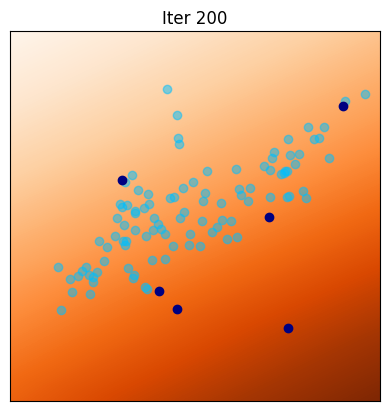

[300/1000], Dloss=-0.0974, Lip(D)=0.9865


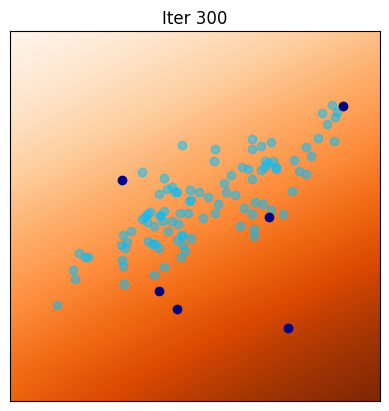

[400/1000], Dloss=-0.0950, Lip(D)=1.0003


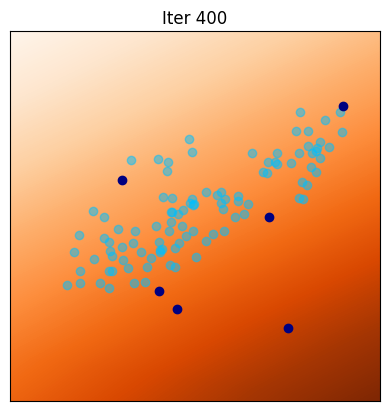

[500/1000], Dloss=-0.1176, Lip(D)=1.0157


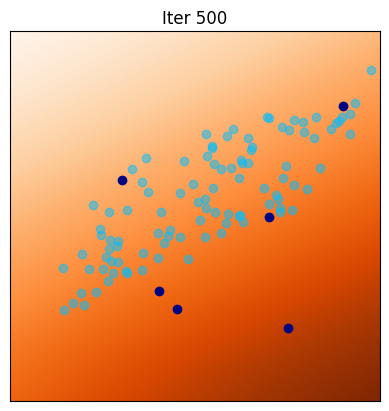

[600/1000], Dloss=-0.1123, Lip(D)=1.0075


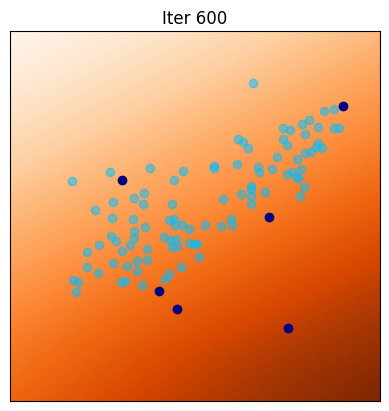

[700/1000], Dloss=-0.1195, Lip(D)=1.0037


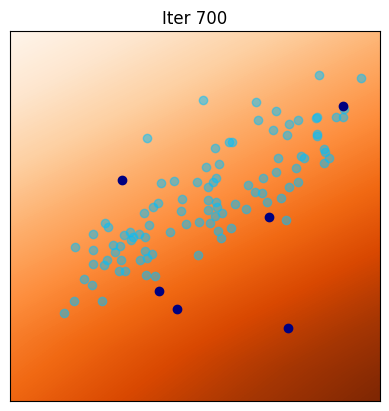

[800/1000], Dloss=-0.1289, Lip(D)=1.0033


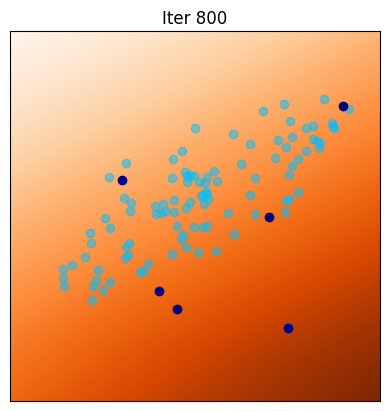

[900/1000], Dloss=-0.1205, Lip(D)=0.9991


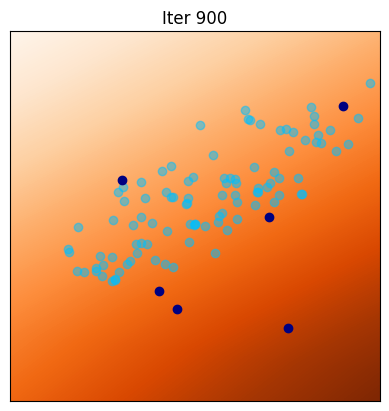

Final estimated Lipschitz constant = 0.9990606307983398


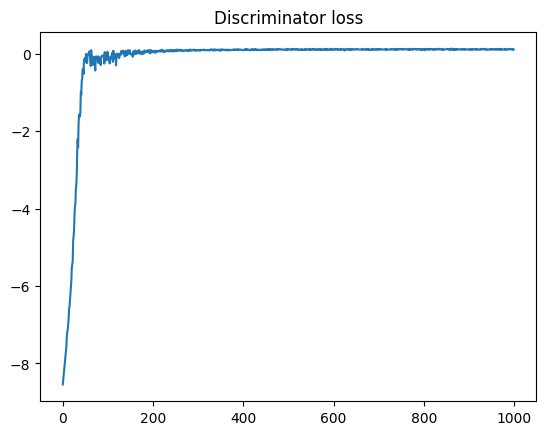

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000
gpw = 10       # parameter for gradient penalty

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0, niterD):
    # UPDATE OF D
    optimD.zero_grad()

    # Generate fake data
    z = torch.randn(b, n_in, device=device)
    x_fake = G(z)

    # Compute WGAN loss for fake data
    D_fake = D(x_fake)
    D_fake_mean = torch.mean(D_fake)

    # Compute WGAN loss for real data
    x_real = y
    D_real = D(x_real)
    D_real_mean = torch.mean(D_real)

    # Compute total discriminator loss
    Dloss = D_fake_mean - D_real_mean

    # Gradient Penalty
    gp = gradient_penalty(D, x_real, x_fake)
    Dloss += gp * gpw

    # Backpropagation and optimization
    Dloss.backward()
    optimD.step()

    # SAVE LOSS
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if iter % iter_display == 0:
        lipschitz_estimate = lipconstant(D, x_real, x_fake).item()
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst, lipschitz_estimate))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter ' + str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant =', lipschitz_estimate)

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()


## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1774	Loss_G: -1.7155	Lip(D)=1.8226
[2/100] 	Loss_D: -0.1468	Loss_G: -1.0114	Lip(D)=1.6257
[3/100] 	Loss_D: -0.1586	Loss_G: -1.8094	Lip(D)=1.5128
[4/100] 	Loss_D: -0.0758	Loss_G: -2.9432	Lip(D)=1.1181
[5/100] 	Loss_D: -0.1567	Loss_G: -9.9449	Lip(D)=1.6068


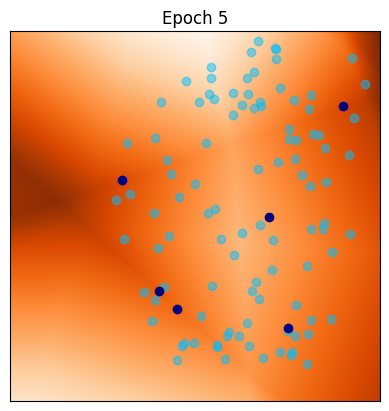

[6/100] 	Loss_D: -0.1790	Loss_G: -11.8595	Lip(D)=1.2415
[7/100] 	Loss_D: -0.1835	Loss_G: -13.2037	Lip(D)=1.4886
[8/100] 	Loss_D: -0.0796	Loss_G: -16.8019	Lip(D)=1.5574
[9/100] 	Loss_D: -0.1279	Loss_G: -18.4810	Lip(D)=1.3627
[10/100] 	Loss_D: -0.0791	Loss_G: -20.8588	Lip(D)=1.2877


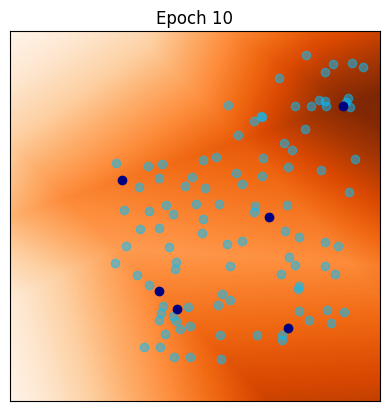

[11/100] 	Loss_D: -0.0570	Loss_G: -21.9279	Lip(D)=1.2086
[12/100] 	Loss_D: -0.1523	Loss_G: -22.7519	Lip(D)=1.3285
[13/100] 	Loss_D: -0.0599	Loss_G: -24.3057	Lip(D)=1.3039
[14/100] 	Loss_D: -0.0985	Loss_G: -26.6225	Lip(D)=1.1182
[15/100] 	Loss_D: -0.1030	Loss_G: -29.4388	Lip(D)=1.3253


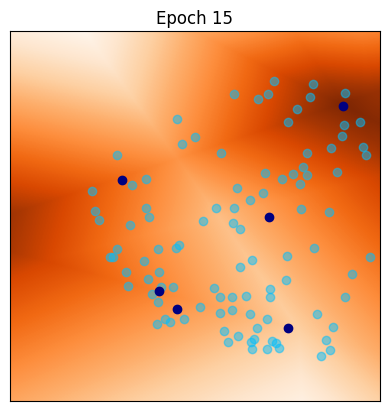

[16/100] 	Loss_D: -0.0176	Loss_G: -29.1610	Lip(D)=1.1588
[17/100] 	Loss_D: -0.0708	Loss_G: -28.6572	Lip(D)=1.3413
[18/100] 	Loss_D: -0.1101	Loss_G: -28.8532	Lip(D)=1.6052
[19/100] 	Loss_D: -0.1040	Loss_G: -34.4979	Lip(D)=1.3753
[20/100] 	Loss_D: -0.0713	Loss_G: -40.3300	Lip(D)=1.3754


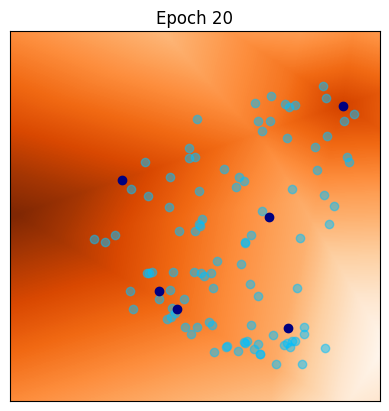

[21/100] 	Loss_D: -0.0854	Loss_G: -39.9409	Lip(D)=1.2796
[22/100] 	Loss_D: -0.0922	Loss_G: -39.1571	Lip(D)=1.3645
[23/100] 	Loss_D: -0.0885	Loss_G: -39.2261	Lip(D)=1.2197
[24/100] 	Loss_D: -0.0596	Loss_G: -44.6928	Lip(D)=1.3352
[25/100] 	Loss_D: -0.0719	Loss_G: -47.3009	Lip(D)=1.4384


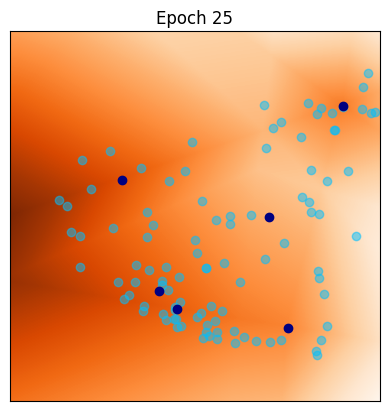

[26/100] 	Loss_D: -0.0667	Loss_G: -45.4400	Lip(D)=1.0468
[27/100] 	Loss_D: -0.0684	Loss_G: -45.5896	Lip(D)=1.3868
[28/100] 	Loss_D: -0.0667	Loss_G: -51.3511	Lip(D)=1.2047
[29/100] 	Loss_D: -0.0369	Loss_G: -54.1100	Lip(D)=1.2335
[30/100] 	Loss_D: -0.0576	Loss_G: -53.4701	Lip(D)=1.3206


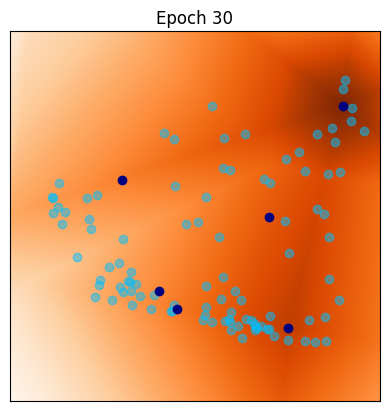

[31/100] 	Loss_D: -0.0500	Loss_G: -55.1330	Lip(D)=1.1489
[32/100] 	Loss_D: -0.0566	Loss_G: -56.0388	Lip(D)=0.9293
[33/100] 	Loss_D: -0.0739	Loss_G: -57.8391	Lip(D)=1.2589
[34/100] 	Loss_D: -0.0681	Loss_G: -64.7810	Lip(D)=1.4821
[35/100] 	Loss_D: -0.0506	Loss_G: -68.8370	Lip(D)=1.1631


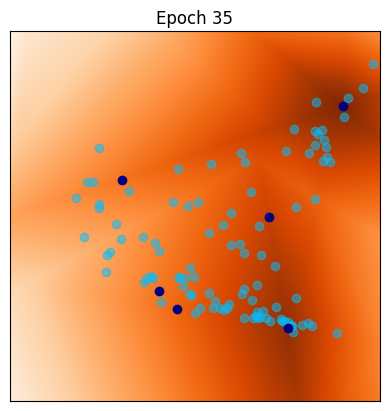

[36/100] 	Loss_D: -0.0936	Loss_G: -68.3492	Lip(D)=1.2395
[37/100] 	Loss_D: -0.0814	Loss_G: -68.3414	Lip(D)=1.1829
[38/100] 	Loss_D: -0.1142	Loss_G: -72.2906	Lip(D)=1.4111
[39/100] 	Loss_D: -0.1030	Loss_G: -74.6016	Lip(D)=1.3129
[40/100] 	Loss_D: -0.0456	Loss_G: -72.8233	Lip(D)=1.1654


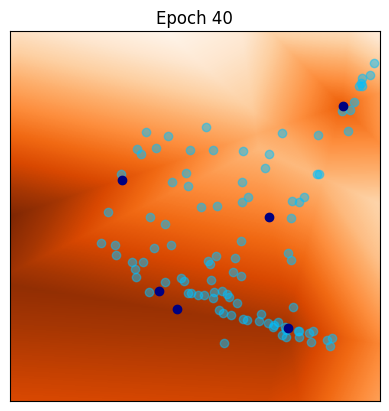

[41/100] 	Loss_D: -0.0823	Loss_G: -75.0938	Lip(D)=1.3662
[42/100] 	Loss_D: -0.0692	Loss_G: -80.8828	Lip(D)=1.0804
[43/100] 	Loss_D: -0.1015	Loss_G: -83.4881	Lip(D)=1.1361
[44/100] 	Loss_D: -0.0777	Loss_G: -86.3838	Lip(D)=1.4606
[45/100] 	Loss_D: -0.0626	Loss_G: -85.2213	Lip(D)=1.3030


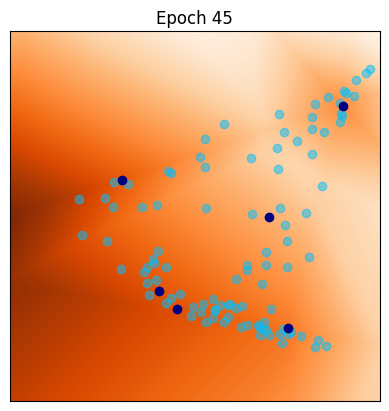

[46/100] 	Loss_D: -0.0520	Loss_G: -86.3631	Lip(D)=1.1520
[47/100] 	Loss_D: -0.0550	Loss_G: -94.7821	Lip(D)=1.4644
[48/100] 	Loss_D: -0.1088	Loss_G: -98.9681	Lip(D)=1.5083
[49/100] 	Loss_D: -0.0763	Loss_G: -98.2073	Lip(D)=1.4072
[50/100] 	Loss_D: -0.1089	Loss_G: -97.3046	Lip(D)=1.3596


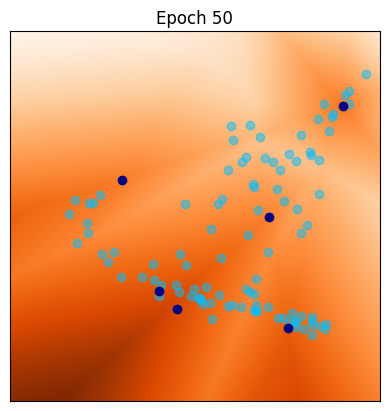

[51/100] 	Loss_D: -0.1103	Loss_G: -102.4962	Lip(D)=1.4314
[52/100] 	Loss_D: -0.0878	Loss_G: -110.0766	Lip(D)=1.6585
[53/100] 	Loss_D: -0.1059	Loss_G: -112.2603	Lip(D)=1.5627
[54/100] 	Loss_D: -0.1232	Loss_G: -113.1373	Lip(D)=1.4920
[55/100] 	Loss_D: -0.1049	Loss_G: -116.3076	Lip(D)=1.3912


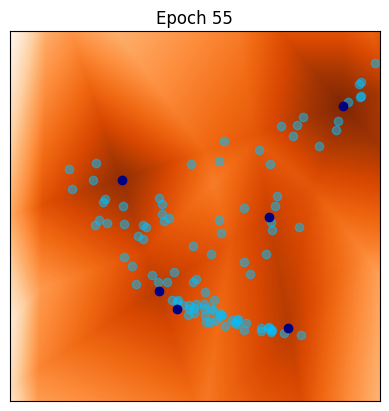

[56/100] 	Loss_D: -0.1104	Loss_G: -119.3168	Lip(D)=1.4688
[57/100] 	Loss_D: -0.1071	Loss_G: -123.3826	Lip(D)=1.3464
[58/100] 	Loss_D: -0.1191	Loss_G: -126.2590	Lip(D)=1.3717
[59/100] 	Loss_D: -0.1187	Loss_G: -124.2504	Lip(D)=1.5721
[60/100] 	Loss_D: -0.0959	Loss_G: -130.4051	Lip(D)=1.4105


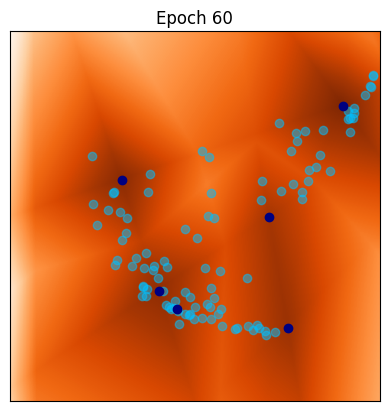

[61/100] 	Loss_D: -0.1107	Loss_G: -134.7494	Lip(D)=1.4784
[62/100] 	Loss_D: -0.1070	Loss_G: -134.8111	Lip(D)=1.3022
[63/100] 	Loss_D: -0.0789	Loss_G: -135.5887	Lip(D)=1.5119
[64/100] 	Loss_D: -0.1174	Loss_G: -138.6314	Lip(D)=1.3916
[65/100] 	Loss_D: -0.0905	Loss_G: -141.6972	Lip(D)=1.4375


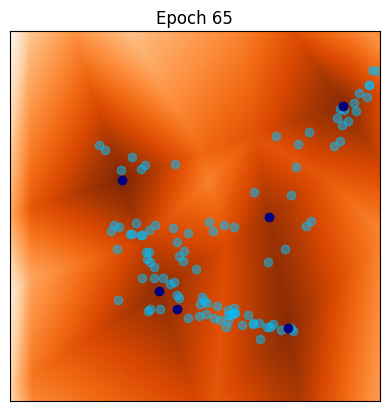

[66/100] 	Loss_D: -0.1060	Loss_G: -142.9547	Lip(D)=1.3250
[67/100] 	Loss_D: -0.1065	Loss_G: -143.6838	Lip(D)=1.3896
[68/100] 	Loss_D: -0.0982	Loss_G: -146.6864	Lip(D)=1.4493
[69/100] 	Loss_D: -0.1113	Loss_G: -145.4674	Lip(D)=1.3432
[70/100] 	Loss_D: -0.0813	Loss_G: -145.4284	Lip(D)=1.3787


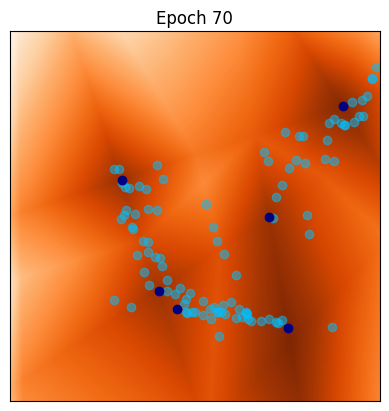

[71/100] 	Loss_D: -0.0676	Loss_G: -151.0534	Lip(D)=1.3948
[72/100] 	Loss_D: -0.0922	Loss_G: -144.7498	Lip(D)=1.2055
[73/100] 	Loss_D: -0.1002	Loss_G: -144.3882	Lip(D)=1.3351
[74/100] 	Loss_D: -0.0869	Loss_G: -145.2592	Lip(D)=1.2932
[75/100] 	Loss_D: -0.1044	Loss_G: -147.3848	Lip(D)=1.2547


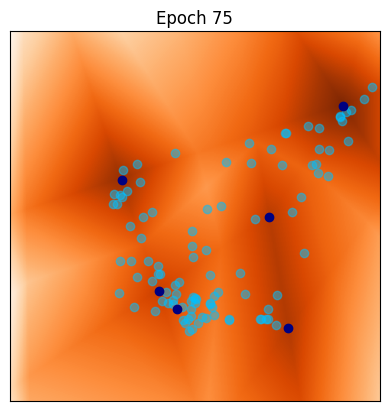

[76/100] 	Loss_D: -0.1123	Loss_G: -152.3747	Lip(D)=1.2594
[77/100] 	Loss_D: -0.0905	Loss_G: -149.7948	Lip(D)=1.3583
[78/100] 	Loss_D: -0.1065	Loss_G: -148.9497	Lip(D)=1.3600
[79/100] 	Loss_D: -0.0809	Loss_G: -148.8326	Lip(D)=1.3554
[80/100] 	Loss_D: -0.1120	Loss_G: -148.2251	Lip(D)=1.3596


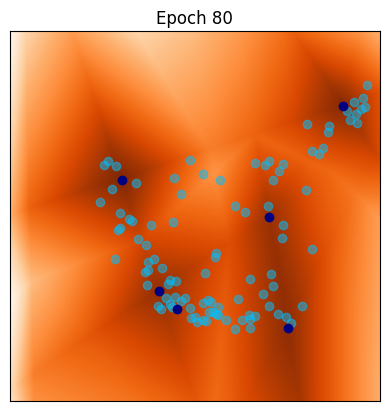

[81/100] 	Loss_D: -0.1019	Loss_G: -150.7282	Lip(D)=1.2638
[82/100] 	Loss_D: -0.0523	Loss_G: -153.5252	Lip(D)=1.2439
[83/100] 	Loss_D: -0.0854	Loss_G: -155.8731	Lip(D)=1.2738
[84/100] 	Loss_D: -0.0804	Loss_G: -155.7535	Lip(D)=1.2256
[85/100] 	Loss_D: -0.0698	Loss_G: -154.3135	Lip(D)=1.3670


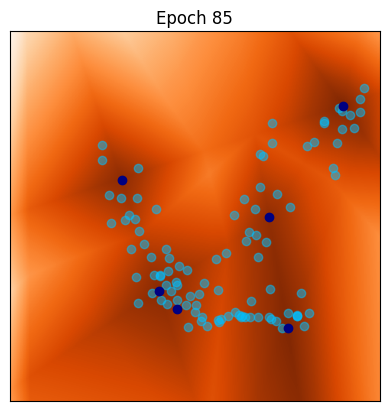

[86/100] 	Loss_D: -0.0725	Loss_G: -153.4541	Lip(D)=1.5488
[87/100] 	Loss_D: -0.0719	Loss_G: -155.2870	Lip(D)=1.4506
[88/100] 	Loss_D: -0.0794	Loss_G: -152.9103	Lip(D)=1.4689
[89/100] 	Loss_D: -0.0898	Loss_G: -151.0429	Lip(D)=1.2885
[90/100] 	Loss_D: -0.1053	Loss_G: -157.5263	Lip(D)=1.2932


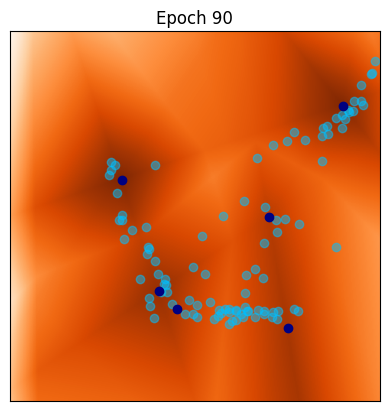

[91/100] 	Loss_D: -0.0873	Loss_G: -154.7244	Lip(D)=1.3247
[92/100] 	Loss_D: -0.0934	Loss_G: -153.2982	Lip(D)=1.5174
[93/100] 	Loss_D: -0.0600	Loss_G: -158.3635	Lip(D)=1.4517
[94/100] 	Loss_D: -0.0800	Loss_G: -161.7406	Lip(D)=1.1521
[95/100] 	Loss_D: -0.0999	Loss_G: -160.1301	Lip(D)=1.2828


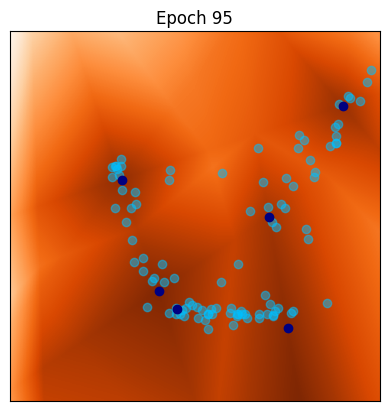

[96/100] 	Loss_D: -0.0886	Loss_G: -159.8949	Lip(D)=1.4486
[97/100] 	Loss_D: -0.0863	Loss_G: -164.6957	Lip(D)=1.4802
[98/100] 	Loss_D: -0.0994	Loss_G: -160.7784	Lip(D)=1.2899
[99/100] 	Loss_D: -0.1030	Loss_G: -165.3544	Lip(D)=1.3052


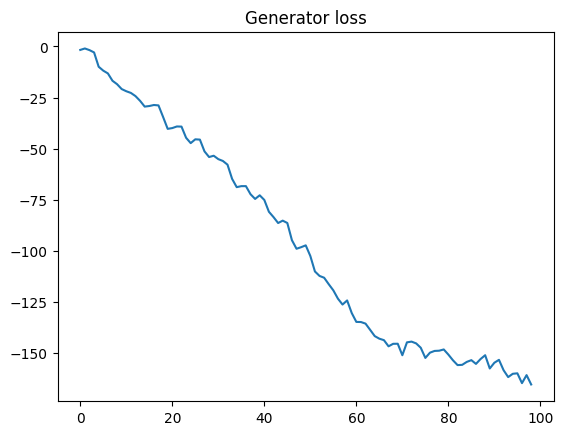

<All keys matched successfully>

In [ ]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z).detach()

        Dloss = torch.mean(D(x)) + gpw * gradient_penalty(D, x, y) - torch.mean(D(y))

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
      optimG.zero_grad()  # Reset gradients for the generator

      # Generate fake data
      z = torch.randn(b, n_in, device=device)
      x_fake = G(z)

      # Critic evaluates the fake data
      D_fake = D(x_fake)
      Gloss = -torch.mean(D_fake)  # Maximize the critic's output (minimize the negative)

      # Backward pass and optimize
      Gloss.backward()
      optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

From what I have tried I can say that:

1. Adjust learning rates based on the performance.
2. Balance the number of updates for discriminator and generator. If the number of Generator is not samller than the number of updates of the discrimantor the model faces problems to converge.
3. Change the batches sizes for stability and convergence speed.
4. Choose a good number of `gpw` to regularize the model
6. Possibly implement others techniques of regularization sucha as dropout and early stopping.



[1/50] 	Loss_D: -0.1780	Loss_G: -1.1375	Lip(D)=1.9008
[2/50] 	Loss_D: -0.1831	Loss_G: -1.2652	Lip(D)=1.5532
[3/50] 	Loss_D: -0.1725	Loss_G: -0.7527	Lip(D)=1.3389
[4/50] 	Loss_D: -0.1025	Loss_G: -0.8356	Lip(D)=1.4621
[5/50] 	Loss_D: -0.0775	Loss_G: -1.2893	Lip(D)=1.2972


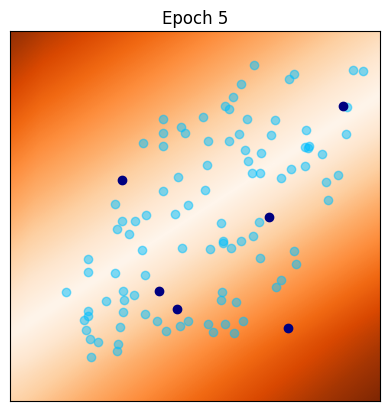

[6/50] 	Loss_D: -0.0638	Loss_G: -2.0415	Lip(D)=1.3433
[7/50] 	Loss_D: -0.0654	Loss_G: -2.2566	Lip(D)=1.2380
[8/50] 	Loss_D: -0.0231	Loss_G: -2.0635	Lip(D)=1.1021
[9/50] 	Loss_D: -0.0298	Loss_G: 0.1656	Lip(D)=1.0494
[10/50] 	Loss_D: -0.0691	Loss_G: 2.9042	Lip(D)=1.4102


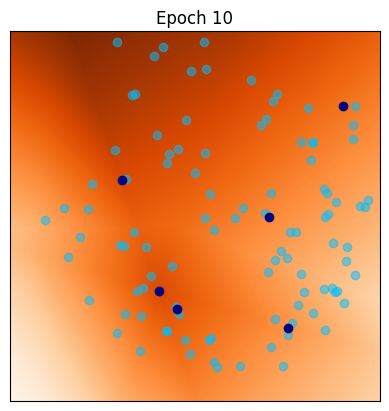

[11/50] 	Loss_D: -0.0990	Loss_G: 1.6757	Lip(D)=1.4762
[12/50] 	Loss_D: -0.1514	Loss_G: -0.3794	Lip(D)=1.3957
[13/50] 	Loss_D: -0.0756	Loss_G: -1.4968	Lip(D)=1.2325
[14/50] 	Loss_D: -0.0428	Loss_G: -1.7158	Lip(D)=1.2459
[15/50] 	Loss_D: -0.0862	Loss_G: -2.4632	Lip(D)=1.2816


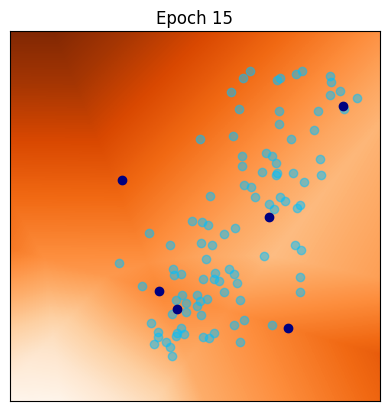

[16/50] 	Loss_D: -0.1117	Loss_G: -3.6273	Lip(D)=1.2984
[17/50] 	Loss_D: -0.1130	Loss_G: -3.8336	Lip(D)=1.2687
[18/50] 	Loss_D: -0.1411	Loss_G: -2.6613	Lip(D)=1.4445
[19/50] 	Loss_D: -0.1182	Loss_G: -2.5133	Lip(D)=1.3741
[20/50] 	Loss_D: -0.0564	Loss_G: -2.5937	Lip(D)=1.5576


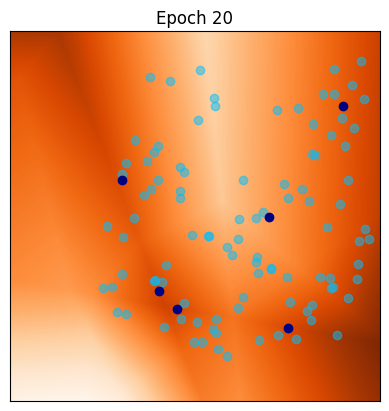

[21/50] 	Loss_D: -0.0158	Loss_G: -2.7084	Lip(D)=1.3368
[22/50] 	Loss_D: -0.1027	Loss_G: -3.1166	Lip(D)=1.6802
[23/50] 	Loss_D: -0.0944	Loss_G: -3.4504	Lip(D)=1.2048
[24/50] 	Loss_D: -0.0753	Loss_G: -4.0653	Lip(D)=1.2225
[25/50] 	Loss_D: -0.0862	Loss_G: -5.2780	Lip(D)=1.3179


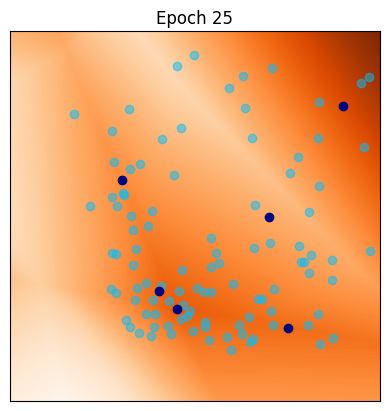

[26/50] 	Loss_D: -0.0733	Loss_G: -6.3636	Lip(D)=1.0051
[27/50] 	Loss_D: -0.0710	Loss_G: -6.7399	Lip(D)=1.2236
[28/50] 	Loss_D: -0.0672	Loss_G: -6.8884	Lip(D)=1.1101
[29/50] 	Loss_D: -0.0559	Loss_G: -6.5154	Lip(D)=1.4794
[30/50] 	Loss_D: -0.0759	Loss_G: -6.7370	Lip(D)=1.4063


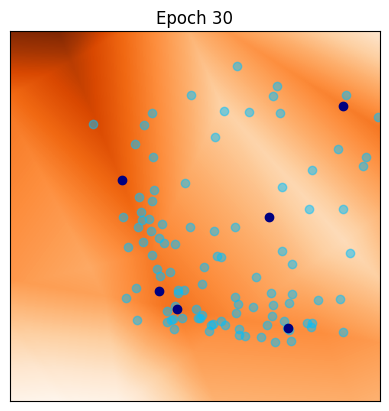

[31/50] 	Loss_D: -0.0760	Loss_G: -7.4621	Lip(D)=1.1945
[32/50] 	Loss_D: -0.0305	Loss_G: -7.7869	Lip(D)=1.1347
[33/50] 	Loss_D: -0.0928	Loss_G: -8.0923	Lip(D)=1.3797
[34/50] 	Loss_D: -0.0631	Loss_G: -8.2969	Lip(D)=1.3427
[35/50] 	Loss_D: -0.0608	Loss_G: -9.7427	Lip(D)=1.1819


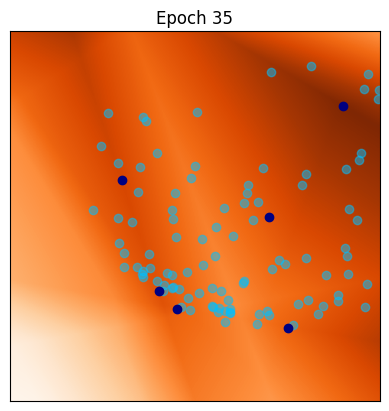

[36/50] 	Loss_D: -0.0475	Loss_G: -12.2542	Lip(D)=1.5525
[37/50] 	Loss_D: -0.1098	Loss_G: -12.9348	Lip(D)=1.3474
[38/50] 	Loss_D: -0.0728	Loss_G: -13.7844	Lip(D)=1.4191
[39/50] 	Loss_D: -0.0811	Loss_G: -14.1842	Lip(D)=1.2622
[40/50] 	Loss_D: -0.0912	Loss_G: -14.6171	Lip(D)=1.1695


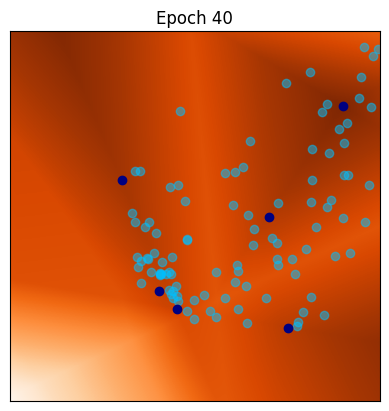

[41/50] 	Loss_D: -0.0734	Loss_G: -16.0625	Lip(D)=1.2244
[42/50] 	Loss_D: -0.1016	Loss_G: -15.3559	Lip(D)=1.4320
[43/50] 	Loss_D: -0.1455	Loss_G: -14.4355	Lip(D)=1.4924
[44/50] 	Loss_D: -0.1151	Loss_G: -13.5602	Lip(D)=1.5695
[45/50] 	Loss_D: -0.0858	Loss_G: -13.2398	Lip(D)=1.4011


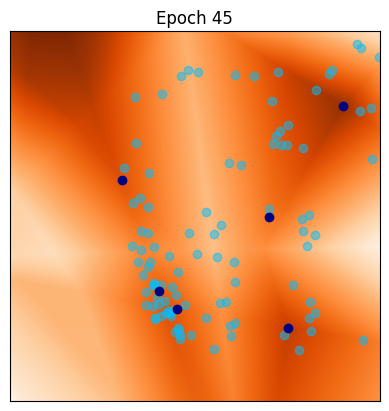

[46/50] 	Loss_D: -0.0984	Loss_G: -14.2658	Lip(D)=1.1527
[47/50] 	Loss_D: -0.1070	Loss_G: -16.0377	Lip(D)=1.3406
[48/50] 	Loss_D: -0.1053	Loss_G: -16.8801	Lip(D)=1.2828
[49/50] 	Loss_D: -0.1049	Loss_G: -17.1804	Lip(D)=1.3498


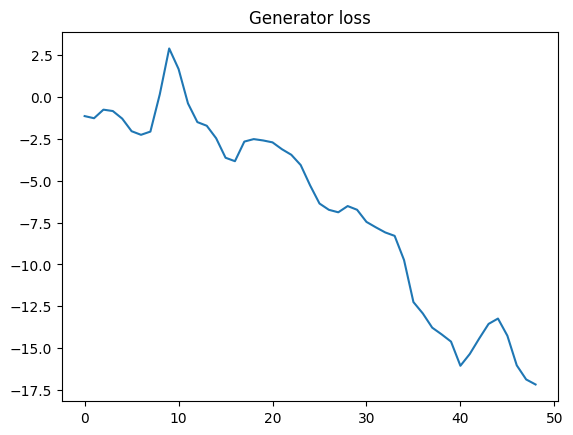

<All keys matched successfully>

In [ ]:
## parameters for training
n_epochs = 50
niterD=1000
niterG=10
gpw = .1

lr = 0.001      # learning rate for generator
lrdisc = 0.001  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z).detach()

        Dloss = torch.mean(D(x)) + gpw * gradient_penalty(D, x, y) - torch.mean(D(y))

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
      optimG.zero_grad()  # Reset gradients for the generator

      # Generate fake data
      z = torch.randn(b, n_in, device=device)
      x_fake = G(z)

      # Critic evaluates the fake data
      D_fake = D(x_fake)
      Gloss = -torch.mean(D_fake)  # Maximize the critic's output (minimize the negative)

      # Backward pass and optimize
      Gloss.backward()
      optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

**Answer** In this case, the generator is trained to generate data that are really close(indistiguable) from the region determined by the discriminator. So, the model can produce limited diversity in generated samples and loss divergence.

[0/10], Gloss=-0.0649


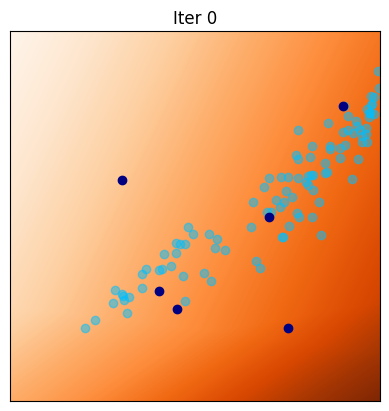

[3/10], Gloss=-0.1001


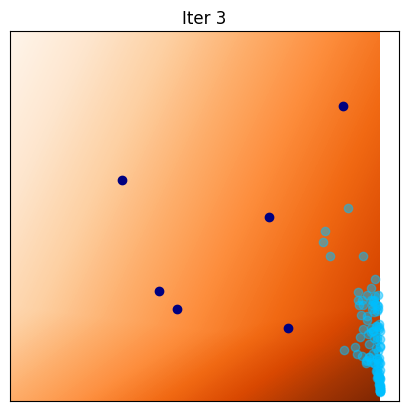

[6/10], Gloss=-0.1311


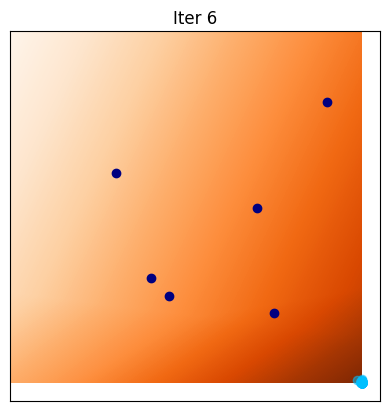

[9/10], Gloss=-0.1327


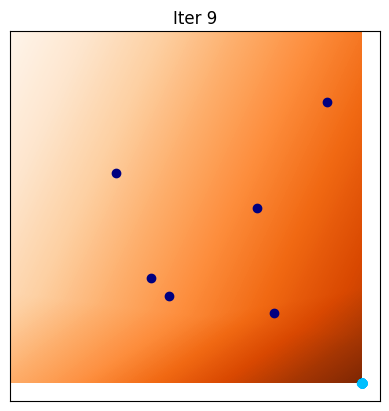

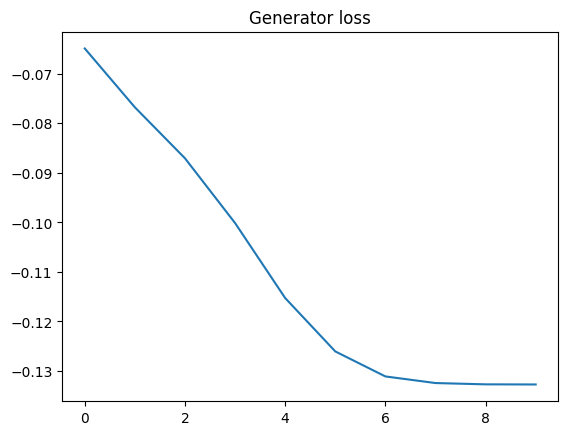

<All keys matched successfully>

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lr = 0.05
niterG = 10

optimG = optim.Adam(G.parameters(), lr=lr)

iter_display = 3  # display current configuration each iter_display iteration

Glosses = []

############################
### Train generator (niterG iterations)
############################
for iter in range(0,niterG):
  optimG.zero_grad()  # Reset gradients for the generator

  # Generate fake data
  z = torch.randn(b, n_in, device=device)
  x_fake = G(z)

  # Critic evaluates the fake data
  D_fake = D(x_fake)
  Gloss = -torch.mean(D_fake)  # Maximize the critic's output (minimize the negative)

  # Backward pass and optimize
  Gloss.backward()
  optimG.step()
  Glosst = Gloss.item()
  Glosses.append(Glosst)

  if iter % iter_display == 0:
      print("[%d/%d], Gloss=%.4f" % (iter, niterG, Glosst))
      Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
      x = G(z)
      xd = x.detach().squeeze(1)
      strtitle = "Iter " + str(iter)
      fig = plt.figure(dpi=100)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(Dxgrid, cmap="Oranges", extent=extent)  # discriminator
      plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
      plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
      plt.title(strtitle)
      plt.show()

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 0.722279


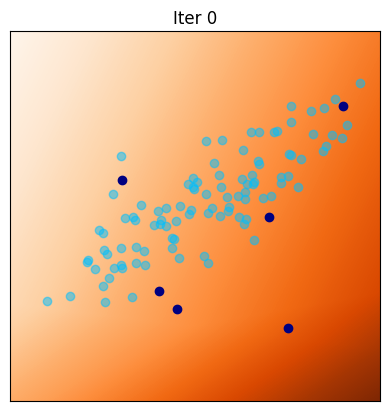

[100/1000], 0.324744


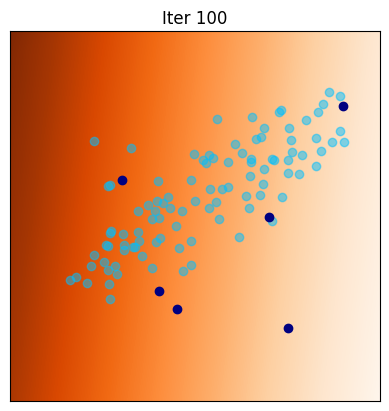

[200/1000], 0.223689


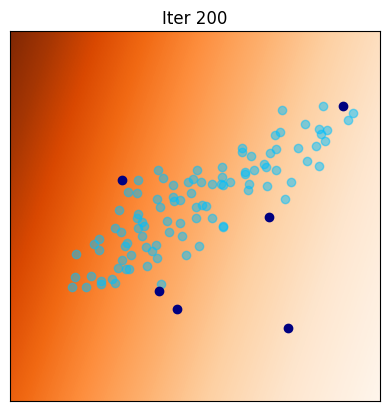

[300/1000], 0.222358


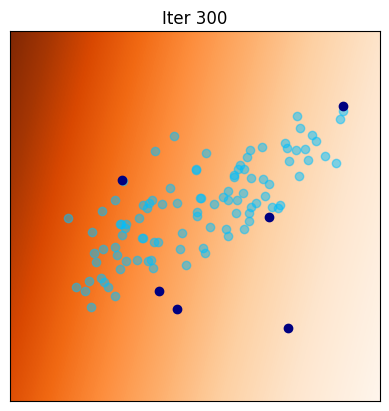

[400/1000], 0.221794


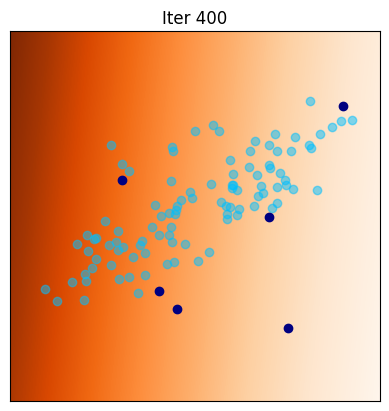

[500/1000], 0.219309


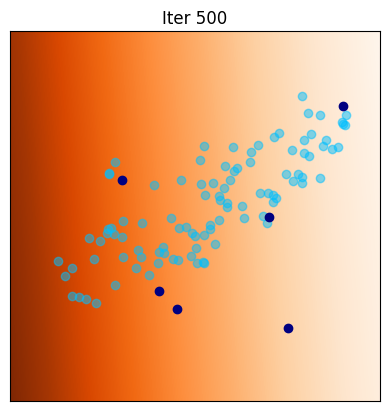

[600/1000], 0.219028


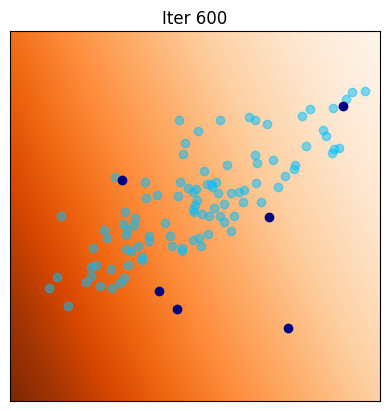

[700/1000], 0.216972


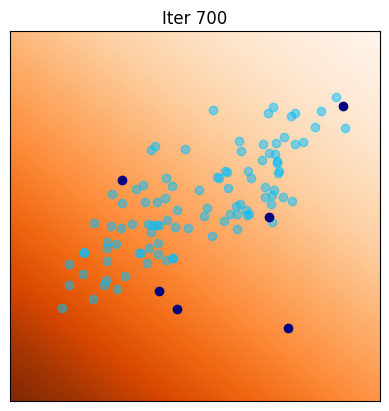

[800/1000], 0.215048


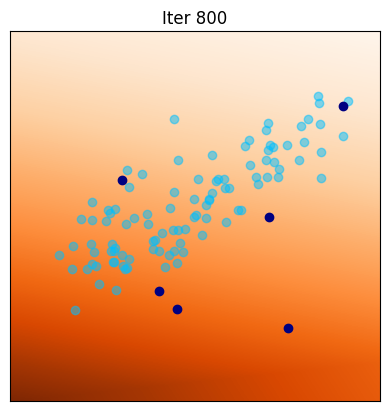

[900/1000], 0.211534


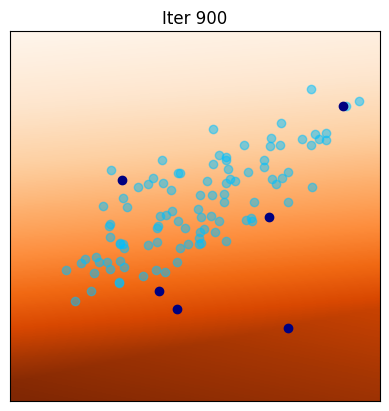

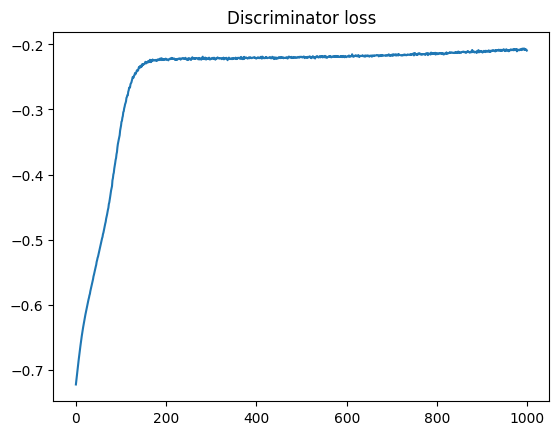

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):
    ### UPDATE OF D ###
    optimD.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x = G(z).detach()

    inp = torch.cat((D(y), D(x)))
    target = torch.cat((V1, V0))

    Dloss = criterion(inp, target)
    # Equivalently:
    # Dloss = - torch.mean(torch.log(sig(D(y)))) - torch.mean(torch.log(1 - sig(D(x))))

    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 1.1636	Loss_G: -0.5996


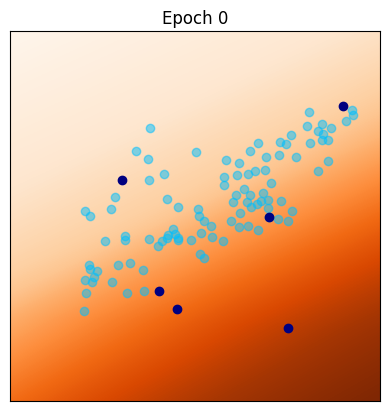

[1/100] 	Loss_D: 1.0222	Loss_G: -0.5427
[2/100] 	Loss_D: 0.9658	Loss_G: -0.4878
[3/100] 	Loss_D: 0.9130	Loss_G: -0.4434
[4/100] 	Loss_D: 0.8842	Loss_G: -0.4201
[5/100] 	Loss_D: 0.8463	Loss_G: -0.3796
[6/100] 	Loss_D: 0.7661	Loss_G: -0.4617
[7/100] 	Loss_D: 0.7959	Loss_G: -0.3909
[8/100] 	Loss_D: 0.8662	Loss_G: -0.4764
[9/100] 	Loss_D: 0.8483	Loss_G: -0.5210
[10/100] 	Loss_D: 0.8642	Loss_G: -0.6054


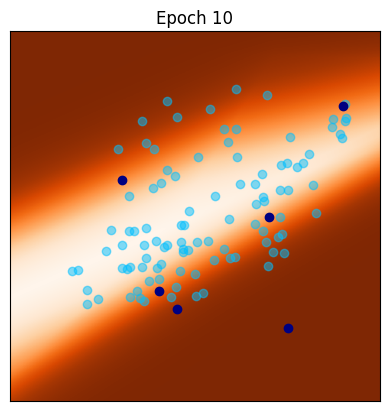

[11/100] 	Loss_D: 0.9657	Loss_G: -0.5242
[12/100] 	Loss_D: 0.9961	Loss_G: -0.5672
[13/100] 	Loss_D: 1.0131	Loss_G: -0.5597
[14/100] 	Loss_D: 1.0864	Loss_G: -0.5954
[15/100] 	Loss_D: 1.1338	Loss_G: -0.5670
[16/100] 	Loss_D: 1.0667	Loss_G: -0.6393
[17/100] 	Loss_D: 1.0614	Loss_G: -0.5737
[18/100] 	Loss_D: 1.1167	Loss_G: -0.5068
[19/100] 	Loss_D: 1.0035	Loss_G: -0.5491
[20/100] 	Loss_D: 1.0125	Loss_G: -0.6054


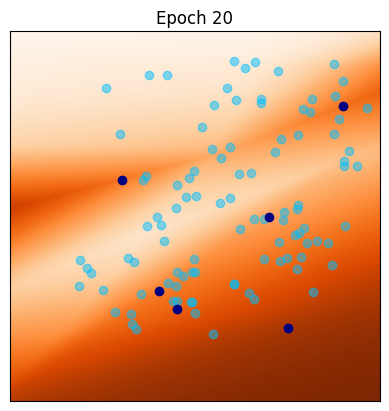

[21/100] 	Loss_D: 0.9992	Loss_G: -0.5344
[22/100] 	Loss_D: 1.0137	Loss_G: -0.5457
[23/100] 	Loss_D: 1.0397	Loss_G: -0.5488
[24/100] 	Loss_D: 0.9992	Loss_G: -0.5923
[25/100] 	Loss_D: 0.9781	Loss_G: -0.5989
[26/100] 	Loss_D: 0.9732	Loss_G: -0.4868
[27/100] 	Loss_D: 0.9023	Loss_G: -0.5644
[28/100] 	Loss_D: 0.9567	Loss_G: -0.4863
[29/100] 	Loss_D: 0.9330	Loss_G: -0.5167
[30/100] 	Loss_D: 0.9317	Loss_G: -0.4339


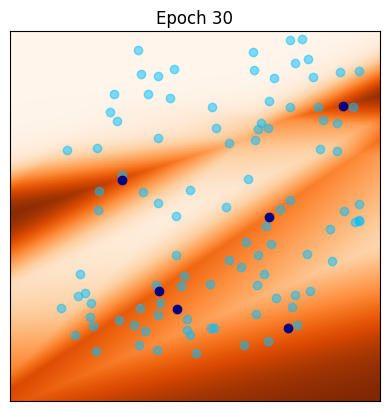

[31/100] 	Loss_D: 0.8966	Loss_G: -0.5132
[32/100] 	Loss_D: 0.8894	Loss_G: -0.4389
[33/100] 	Loss_D: 0.8282	Loss_G: -0.4306
[34/100] 	Loss_D: 0.7945	Loss_G: -0.5224
[35/100] 	Loss_D: 0.8381	Loss_G: -0.4292
[36/100] 	Loss_D: 0.8060	Loss_G: -0.4808
[37/100] 	Loss_D: 0.8158	Loss_G: -0.4275
[38/100] 	Loss_D: 0.7934	Loss_G: -0.3903
[39/100] 	Loss_D: 0.7916	Loss_G: -0.4147
[40/100] 	Loss_D: 0.7373	Loss_G: -0.4581


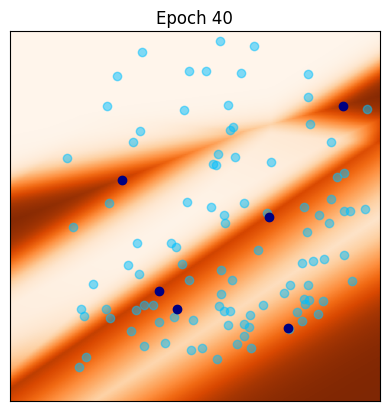

[41/100] 	Loss_D: 0.7332	Loss_G: -0.4728
[42/100] 	Loss_D: 0.8474	Loss_G: -0.3944
[43/100] 	Loss_D: 0.6433	Loss_G: -0.5344
[44/100] 	Loss_D: 0.8049	Loss_G: -0.4858
[45/100] 	Loss_D: 0.7224	Loss_G: -0.4441
[46/100] 	Loss_D: 0.8403	Loss_G: -0.3732
[47/100] 	Loss_D: 0.7470	Loss_G: -0.4581
[48/100] 	Loss_D: 0.7573	Loss_G: -0.4687
[49/100] 	Loss_D: 0.7293	Loss_G: -0.5284
[50/100] 	Loss_D: 0.7847	Loss_G: -0.3686


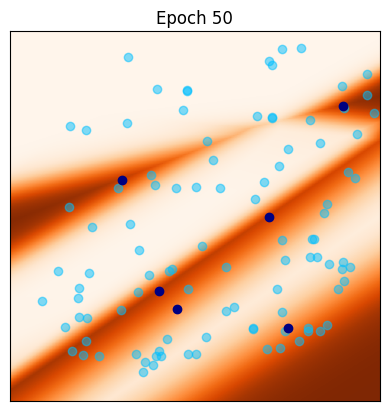

[51/100] 	Loss_D: 0.8199	Loss_G: -0.4125
[52/100] 	Loss_D: 0.7888	Loss_G: -0.5015
[53/100] 	Loss_D: 0.8520	Loss_G: -0.4351
[54/100] 	Loss_D: 0.7539	Loss_G: -0.4602
[55/100] 	Loss_D: 0.7846	Loss_G: -0.4763
[56/100] 	Loss_D: 0.8130	Loss_G: -0.4809
[57/100] 	Loss_D: 0.7706	Loss_G: -0.4954
[58/100] 	Loss_D: 0.8270	Loss_G: -0.5601
[59/100] 	Loss_D: 0.8420	Loss_G: -0.4339
[60/100] 	Loss_D: 0.7450	Loss_G: -0.6202


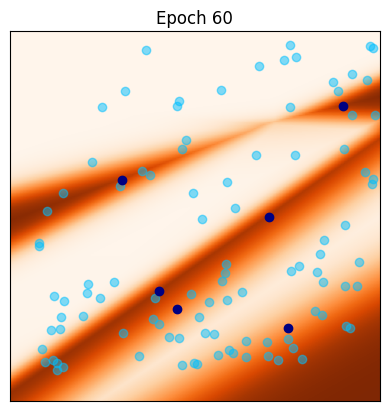

[61/100] 	Loss_D: 0.8579	Loss_G: -0.4239
[62/100] 	Loss_D: 0.8825	Loss_G: -0.4771
[63/100] 	Loss_D: 0.8538	Loss_G: -0.5485
[64/100] 	Loss_D: 0.8430	Loss_G: -0.4773
[65/100] 	Loss_D: 0.7841	Loss_G: -0.4376
[66/100] 	Loss_D: 0.8538	Loss_G: -0.4400
[67/100] 	Loss_D: 0.9443	Loss_G: -0.3459
[68/100] 	Loss_D: 0.7973	Loss_G: -0.5117
[69/100] 	Loss_D: 0.8409	Loss_G: -0.4161
[70/100] 	Loss_D: 0.8094	Loss_G: -0.4487


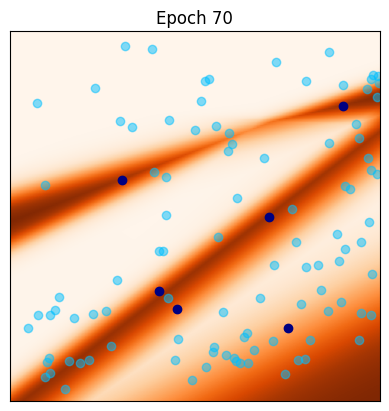

[71/100] 	Loss_D: 0.8773	Loss_G: -0.3754
[72/100] 	Loss_D: 0.8371	Loss_G: -0.6468
[73/100] 	Loss_D: 0.9314	Loss_G: -0.4362
[74/100] 	Loss_D: 0.8702	Loss_G: -0.5218
[75/100] 	Loss_D: 0.8765	Loss_G: -0.4674
[76/100] 	Loss_D: 0.8171	Loss_G: -0.5362
[77/100] 	Loss_D: 0.8282	Loss_G: -0.4555
[78/100] 	Loss_D: 0.7914	Loss_G: -0.4579
[79/100] 	Loss_D: 0.8415	Loss_G: -0.4867
[80/100] 	Loss_D: 0.7943	Loss_G: -0.5212


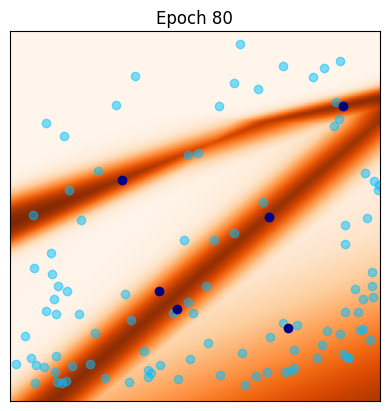

[81/100] 	Loss_D: 0.9260	Loss_G: -0.4370
[82/100] 	Loss_D: 0.8115	Loss_G: -0.4264
[83/100] 	Loss_D: 0.8533	Loss_G: -0.4884
[84/100] 	Loss_D: 0.8987	Loss_G: -0.3971
[85/100] 	Loss_D: 0.8129	Loss_G: -0.5069
[86/100] 	Loss_D: 0.7857	Loss_G: -0.3643
[87/100] 	Loss_D: 0.8483	Loss_G: -0.4153
[88/100] 	Loss_D: 0.8154	Loss_G: -0.4795
[89/100] 	Loss_D: 0.8106	Loss_G: -0.3519
[90/100] 	Loss_D: 0.8438	Loss_G: -0.3710


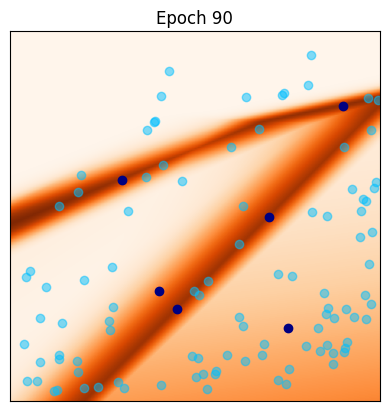

[91/100] 	Loss_D: 0.7907	Loss_G: -0.4401
[92/100] 	Loss_D: 0.8345	Loss_G: -0.3803
[93/100] 	Loss_D: 0.7567	Loss_G: -0.4297
[94/100] 	Loss_D: 0.8473	Loss_G: -0.4327
[95/100] 	Loss_D: 0.7968	Loss_G: -0.3509
[96/100] 	Loss_D: 0.8181	Loss_G: -0.4661
[97/100] 	Loss_D: 0.7086	Loss_G: -0.5296
[98/100] 	Loss_D: 0.7371	Loss_G: -0.3951
[99/100] 	Loss_D: 0.8368	Loss_G: -0.4761


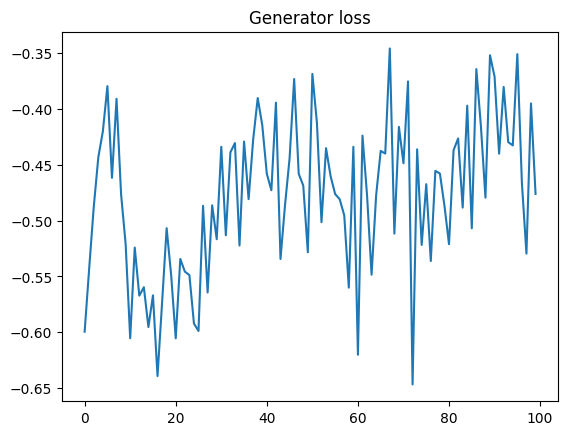

In [ ]:
lr = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=100
niterG=1

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([b/n]).to(device))

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z).detach()

        Dloss = torch.mean(D(x)) + gpw * gradient_penalty(D, x, y) - torch.mean(D(y))

        Dloss.backward()
        optimD.step()


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
      optimG.zero_grad()  # Reset gradients for the generator

      # Generate fake data
      z = torch.randn(b, n_in, device=device)
      x_fake = G(z)

      # Critic evaluates the fake data
      D_fake = D(x_fake)
      Gloss = -torch.mean(D_fake)  # Maximize the critic's output (minimize the negative)

      # Backward pass and optimize
      Gloss.backward()
      optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()